<a href="https://colab.research.google.com/github/TracyWu7724/stats507-final-project/blob/main/Codes/Finetuned_t5_cnn_bo_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing the Data

Load the required libraies in Python

In [ ]:
!pip install transformers evaluate datasets transformers[torch] rouge_score nltk optuna scikit-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 6.4 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=340885996218ec09228fbf02a1bac173a9685b22a36ba428e60c52cf0fd90799
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599

## Load dataset

Load the cnn_dailymail dataset for text summarization from hugging_face

In [ ]:
from datasets import load_dataset

ds = load_dataset("abisee/cnn_dailymail", "3.0.0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

### dataset shape

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

### dataset sample

Data Fields
*   id: a string containing the heximal formated SHA1 hash of the url where the story was retrieved from
*   article: a string containing the body of the news article
*   highlights: a string containing the highlight of the article as written by the article author, as the labeled summary

In [ ]:
ds["train"][0]

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

## Load Tokenizer

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

## Preprocess Data

Goal: The pretrained tokenizer T5 is applied to tokenize the natural language text input (i.e., 'article') and target (i.e., 'highlights') into tensors with a sequence of token IDs, which is obtained by predefined vocabulary to prepare for training.

Tokenizer outputs:
*   input_ids: A sequence of token IDs representing the **source input**, tokenized by T5-small tokenizer with predefined vocabulary
*   labels: A sequence of token IDs representing the **target output**, tokenized by T5-small tokenizer with predefined vocabulary


In [ ]:
def tokenize_input(example):
    # Format the input text with start and end prompts or prefix, which helps the model focus on summarization task.
    start_prompt = "Summarize the conversation. \n\n"
    end_prompt = "\n\nSummary: "
    prompt = [start_prompt + article + end_prompt for article in example["article"]]

    # Tokenize both input and labels data
    inputs = tokenizer(prompt, padding="max_length", truncation=True, return_tensors='pt', max_length=512)
    labels = tokenizer(example["highlights"], padding="max_length", truncation=True, return_tensors='pt', max_length=128)

    # Assign the tokenized input ids and labels to datasets
    example['input_ids'] = inputs.input_ids.squeeze()
    example['labels'] = labels.input_ids.squeeze()

    return example

# Adjust padding token to end_of_sentence(eos)
tokenizer.pad_token = tokenizer.eos_token

# Map the tokenized data to the original dataset
tokenized_datasets = ds.map(tokenize_input, batched=True)

# Remove unnecessary columns
tokenized_datasets = tokenized_datasets.remove_columns(['article', 'highlights', 'id'])

# Simplify the tokenized_dataset for lighter computing workloads
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(10))

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

# Loading the Pre-trained Model

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# Train and Evaluate the Model

explain the compute_metrics function

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate

import nltk
import numpy as np
nltk.download('punkt_tab')

import optuna

metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id) # Replace -100 in the labels as we can't decode them.
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Change into a newline after each sentence for ROUGE
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    # Compute the ROUGE in percentage Format
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)
    result = {key: value * 100 for key, value in result.items()}

    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}


def objective(trial: optuna.Trial):
    # Range of hyperparameters to optimize
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    num_train_epochs = trial.suggest_int('num_train_epochs', 3, 5)

    args = Seq2SeqTrainingArguments(
        f"t5small-cnn-BO-finetuned",
        eval_strategy = "epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        save_total_limit=3,
        predict_with_generate=True,
        fp16=True,
        push_to_hub=False,
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=args,
        compute_metrics=compute_metrics,
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset
    )

    trainer.train()

    eval_result = trainer.evaluate()

    return eval_result["eval_rouge2"]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# create a study object with direction to maximize ROUGE
study = optuna.create_study(direction="maximize")

# define the number of trials for Optuna to run
study.optimize(objective, n_trials=10)

# print the best hyperparameters among the designed number of trials
print(f"Best hyperparameters: {study.best_params}")

[I 2024-12-04 01:30:56,143] A new study created in memory with name: no-name-c54802b2-cd42-453b-8216-4ef105abef77
<ipython-input-9-a2e64b2cd111>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)  # Log scale for learning rate
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,1.093279,12.286300,2.254600,9.194600,11.892100,19.900000
2,No log,1.046452,12.702600,3.201800,10.681300,12.156700,19.900000
3,No log,1.030778,12.702600,3.201800,10.681300,12.156700,19.900000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[I 2024-12-04 02:40:04,003] Trial 0 finished with value: 3.2018 and parameters: {'batch_size': 8, 'learning_rate': 0.00018297426372630127, 'num_train_epochs': 5}. Best is trial 0 with value: 3.2018.
<ipython-input-9-a2e64b2cd111>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)  # Log scale for learning rate


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,0.989094,18.270600,3.883100,15.099600,17.620300,20.000000
2,No log,0.977229,19.150100,3.872500,15.410700,18.409400,20.000000
3,No log,0.974679,15.370200,3.131000,12.429100,14.807800,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[I 2024-12-04 02:40:22,448] Trial 1 finished with value: 3.131 and parameters: {'batch_size': 8, 'learning_rate': 0.00030351011042355637, 'num_train_epochs': 4}. Best is trial 0 with value: 3.2018.
<ipython-input-9-a2e64b2cd111>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)  # Log scale for learning rate


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,1.018900,17.136200,3.926500,13.816600,16.103700,20.000000
2,No log,1.012298,15.021500,2.677000,12.132200,14.223200,20.000000
3,No log,1.009986,15.021500,2.677000,12.132200,14.223200,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[I 2024-12-04 02:40:43,862] Trial 2 finished with value: 2.677 and parameters: {'batch_size': 16, 'learning_rate': 0.0006671946059355851, 'num_train_epochs': 3}. Best is trial 0 with value: 3.2018.
<ipython-input-9-a2e64b2cd111>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)  # Log scale for learning rate


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,1.002554,15.789300,3.098200,12.715600,15.177800,20.000000
2,No log,0.998405,16.116900,3.514900,13.035100,15.485000,20.000000
3,No log,0.996839,16.116900,3.514900,13.035100,15.485000,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[I 2024-12-04 02:41:01,629] Trial 3 finished with value: 3.5149 and parameters: {'batch_size': 16, 'learning_rate': 0.0007135790162443395, 'num_train_epochs': 3}. Best is trial 3 with value: 3.5149.
<ipython-input-9-a2e64b2cd111>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)  # Log scale for learning rate


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,0.957905,16.116900,3.514900,13.035100,15.485000,20.000000
2,No log,0.954941,19.832000,4.362600,15.923200,18.476100,20.000000
3,No log,0.953513,19.832000,4.362600,15.923200,18.476100,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[I 2024-12-04 02:41:19,749] Trial 4 finished with value: 4.3626 and parameters: {'batch_size': 8, 'learning_rate': 2.472873389329721e-05, 'num_train_epochs': 4}. Best is trial 4 with value: 4.3626.
<ipython-input-9-a2e64b2cd111>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)  # Log scale for learning rate


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,0.962394,19.439200,3.989000,15.545500,18.016000,20.000000
2,No log,0.959043,19.084800,3.989000,15.545500,17.753400,20.000000
3,No log,0.957645,19.084800,3.989000,15.545500,17.753400,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[I 2024-12-04 02:41:34,427] Trial 5 finished with value: 3.989 and parameters: {'batch_size': 8, 'learning_rate': 3.216863974058073e-05, 'num_train_epochs': 5}. Best is trial 4 with value: 4.3626.
<ipython-input-9-a2e64b2cd111>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)  # Log scale for learning rate


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,0.994044,19.084800,3.989000,15.545500,17.753400,20.000000
2,No log,0.991936,19.084800,3.989000,15.545500,17.753400,20.000000
3,No log,0.991012,19.084800,3.989000,15.545500,17.753400,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[I 2024-12-04 02:41:47,177] Trial 6 finished with value: 3.989 and parameters: {'batch_size': 16, 'learning_rate': 0.0001231441149809202, 'num_train_epochs': 3}. Best is trial 4 with value: 4.3626.
<ipython-input-9-a2e64b2cd111>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)  # Log scale for learning rate


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,0.971159,19.084800,3.989000,15.545500,17.753400,20.000000
2,No log,0.969043,19.034600,3.503800,15.003900,17.696700,20.000000
3,No log,0.967172,19.034600,3.503800,15.003900,17.696700,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[I 2024-12-04 02:42:07,324] Trial 7 finished with value: 3.5038 and parameters: {'batch_size': 8, 'learning_rate': 4.5851125616972206e-05, 'num_train_epochs': 3}. Best is trial 4 with value: 4.3626.
<ipython-input-9-a2e64b2cd111>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)  # Log scale for learning rate


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,0.995696,18.507400,3.980300,14.949000,17.013500,20.000000
2,No log,0.994073,18.507400,3.980300,14.949000,17.013500,20.000000
3,No log,0.993582,18.507400,3.980300,14.949000,17.013500,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[I 2024-12-04 02:42:19,738] Trial 8 finished with value: 3.9803 and parameters: {'batch_size': 32, 'learning_rate': 2.246890149897083e-05, 'num_train_epochs': 5}. Best is trial 4 with value: 4.3626.
<ipython-input-9-a2e64b2cd111>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)  # Log scale for learning rate


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,0.981454,19.227300,4.504700,15.161400,17.347800,20.000000
2,No log,0.980180,19.103300,4.454800,15.025100,17.173400,20.000000
3,No log,0.977931,19.103300,4.454800,15.025100,17.173400,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[I 2024-12-04 02:42:34,671] Trial 9 finished with value: 4.4548 and parameters: {'batch_size': 8, 'learning_rate': 5.986319096384401e-05, 'num_train_epochs': 5}. Best is trial 9 with value: 4.4548.


Best hyperparameters: {'batch_size': 8, 'learning_rate': 5.986319096384401e-05, 'num_train_epochs': 5}


### Train with optimized hyperparameters

In [ ]:
#login in the Hugging Face platform so that the model can be loaded to hub later
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
best_batch_size = 8

args = Seq2SeqTrainingArguments(
    f"t5small-cnn-BO-finetuned",
    eval_strategy = "epoch",
    learning_rate=6e-5,
    per_device_train_batch_size=best_batch_size,
    per_device_eval_batch_size=best_batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
        model=model,
        args=args,
        compute_metrics=compute_metrics,
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset
    )

trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,0.996513,19.714700,4.521300,15.631600,18.274100,20.000000
2,No log,0.994560,19.714700,4.521300,15.631600,18.274100,20.000000
3,No log,0.988113,19.958800,4.506300,15.582700,18.551700,20.000000
4,No log,0.983688,19.982200,4.507900,15.599400,18.597600,20.000000
5,No log,0.982506,19.982200,4.507900,15.599400,18.597600,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=65, training_loss=0.8865448584923378, metrics={'train_runtime': 26.7902, 'train_samples_per_second': 18.664, 'train_steps_per_second': 2.426, 'total_flos': 67670900736000.0, 'train_loss': 0.8865448584923378, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.9825061559677124,
 'eval_rouge1': 19.9822,
 'eval_rouge2': 4.5079,
 'eval_rougeL': 15.5994,
 'eval_rougeLsum': 18.5976,
 'eval_gen_len': 20.0,
 'eval_runtime': 1.3368,
 'eval_samples_per_second': 7.481,
 'eval_steps_per_second': 1.496,
 'epoch': 5.0}

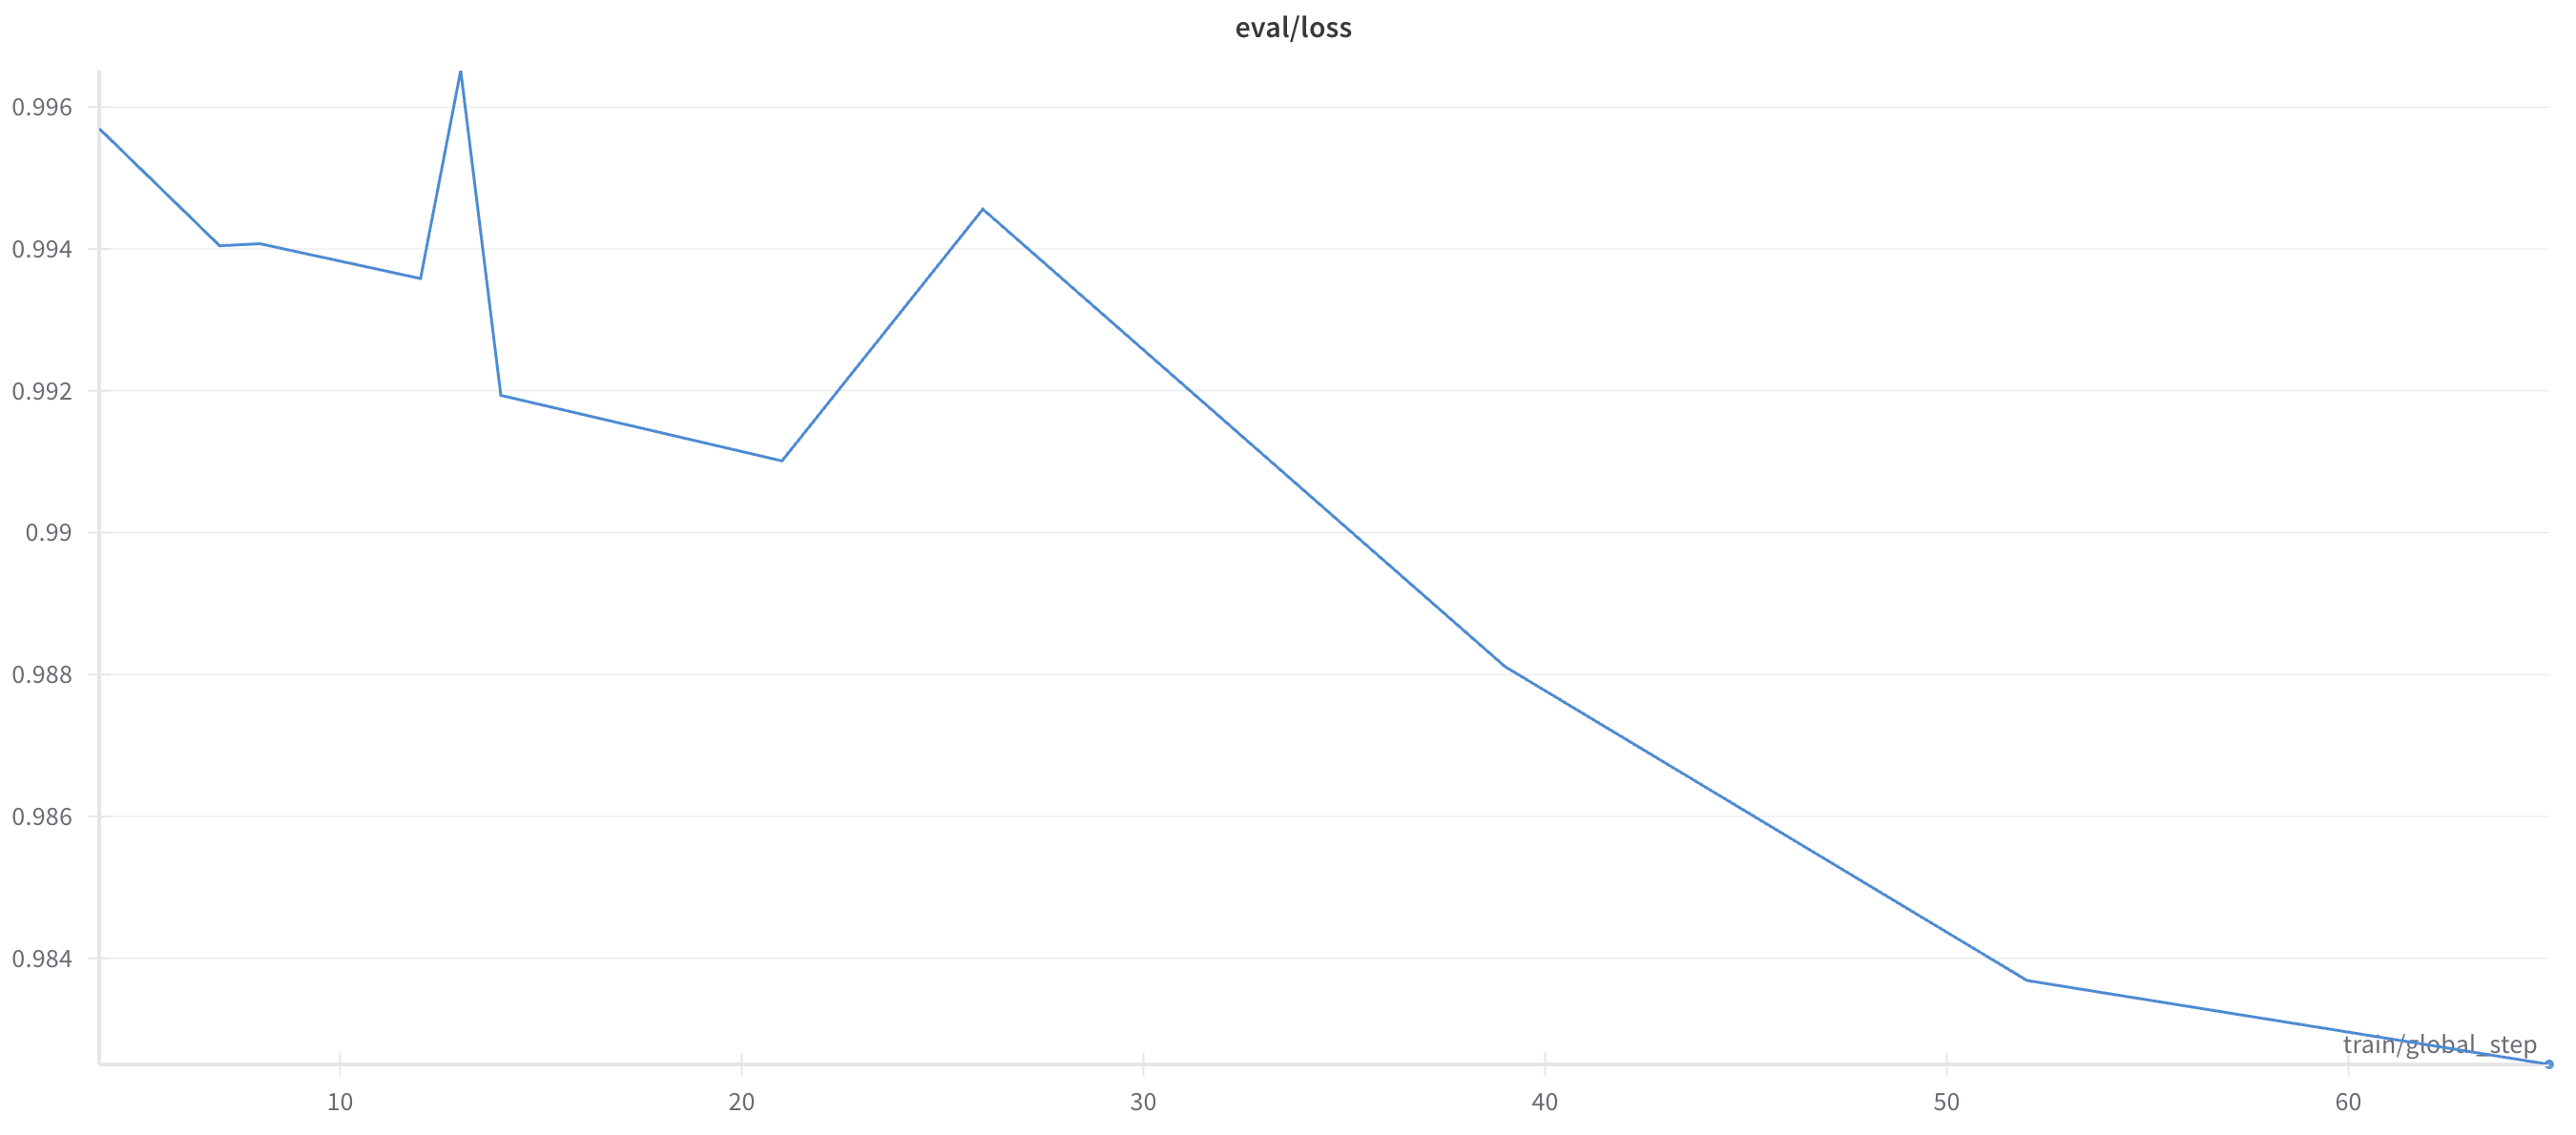

# Load the model to Hugging Face

In [ ]:
model.push_to_hub("t5small-cnn-BO-finetuned")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/TracyWu32/t5small-cnn-BO-finetuned/commit/8a8ba231a72b9bc5d70387133b1d633854bed5c1', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='8a8ba231a72b9bc5d70387133b1d633854bed5c1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/TracyWu32/t5small-cnn-BO-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='TracyWu32/t5small-cnn-BO-finetuned'), pr_revision=None, pr_num=None)

# Prediction with real-world data

In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

import nltk
nltk.download('punkt_tab')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize

from rouge_score import rouge_scorer

import matplotlib.pyplot as plt

def scrape_comapny_desc(raw_file):
    """
    1. set url and header for company description scraping from yahoo finance;
    2. initiate soup object and find the description section using bs library;
    3. inner join the company description with SP500 company list;
    4. save the final result as csv file.
    """
    company_profile = dict()

    headers =  {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36' }

    raw_sp = pd.read_excel(raw_file)

    for i in raw_sp.Symbol:
        link = "https://finance.yahoo.com/quote/" + str(i) + "/profile/"
        yahoo_url = requests.get(link, headers=headers)

        soup = BeautifulSoup(yahoo_url.text, 'html.parser')
        description_section = soup.find('section', {'data-testid': 'description'})

        if description_section:
            description_paragraph = description_section.find('p')
            company_profile[i] = description_paragraph.get_text(strip=True)
        else:
            continue

    raw_company_profile = pd.DataFrame.from_dict(company_profile, orient='index', columns=['Profile'])
    df_merged = raw_company_profile.merge(raw_sp, how='inner', left_index=True, right_on='Symbol')
    df_clean = df_merged[['Company', 'Symbol','Profile']]
    df_clean.to_csv("/Users/tracy/Desktop/UMich/STATS 507/Final_Proj/Real/data_Profile.csv", index=0)

    return df_clean

def get_summary(profile_file, model, tokenizer):
    """
    1. load the pre-trained tokenizer and model
    2. genreate summaries for each company description
    3. save the final result as csv file
    """
    df_desc = pd.read_csv(profile_file)

    summaries = []

    for p in df_desc.Profile:
        inputs = tokenizer(p, return_tensors="pt", max_length=500, truncation=True)
        summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=100, early_stopping=True)
        summary = tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        summaries.append(summary)

    df_desc["Summary"] = summaries

    return df_desc

def extractive_summary(text, word_limit=100):
    """
    1. tokenize the text input with TFIDF
    2. sum the TFIDF score by each row
    3. sort the sentence by its TFIDF sum in descending order
    4. extract words in sorted sentences till the word limit is reached
    """
    sentences = sent_tokenize(text)
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sentences)

    sentence_scores = np.sum(tfidf_matrix.toarray(), axis=1)

    top_sentence_indices = sentence_scores.argsort()[::-1]

    summary = []
    word_count = 0
    for i in top_sentence_indices:
        sentence = sentences[i]
        num_words = len(word_tokenize(sentence))
        if word_count + num_words <= word_limit:
            summary.append(sentence)
            word_count += num_words
        else:
            break

    return ' '.join(summary)

def plot_rouge(df, rouge_type):
    """
    plot the ROUGE evaluation results for two summarization methods
    """
    extractive_rouge = [score[rouge_type].fmeasure for score in df['TFIDF_Rouge']]
    t5_rouge = [score[rouge_type].fmeasure for score in df['T5_Rouge']]

    x_values = range(len(df))

    plt.plot(x_values, extractive_rouge, label='TFIDF')
    plt.plot(x_values, t5_rouge, label='T5')

    plt.xlabel('summary index')
    plt.ylabel(f'{rouge_type} score')
    plt.title(f'TFIDF and T5 Summarization Evaluation in {rouge_type}')

    plt.legend()

    plt.show()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from google.colab import drive
drive.mount('/content/drive')

def main():
    # generate web scrapying from yahoo finance for SP500 company profile description
    # raw_file_path = "/Users/tracy/Desktop/UMich/STATS 507/Final_Proj/Real/data_SP500.xlsx"
    # df_desc = scrape_comapny_desc(raw_file_path)
    # desc_path = "/Users/tracy/Desktop/UMich/STATS 507/Final_Proj/Real/data_Profile.csv"

    # generate company profile summary by two summarization methods
    desc_path = "/content/drive/My Drive/Colab Notebooks/data_Profile.csv"
    model = AutoModelForSeq2SeqLM.from_pretrained("TracyWu32/t5small-cnn-BO-finetuned")
    tokenizer = AutoTokenizer.from_pretrained("t5-small")
    df_final = get_summary(desc_path, model, tokenizer)
    df_final['TFIDF_Summary'] = df_final['Profile'].apply(extractive_summary)

    # calculate the ROUGE evaluate metrics for two summarization methods
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    df_final['TFIDF_Rouge'] = df_final.apply(lambda row: scorer.score(row['Profile'], row['TFIDF_Summary']), axis=1)
    df_final['T5_Rouge'] = df_final.apply(lambda row: scorer.score(row['Profile'], row['Summary']), axis=1)

    # save both summary and evaluate results into csv file
    df_final.to_csv("/content/drive/My Drive/Colab Notebooks/data_Summary.csv")

    return df_final

df_final = main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_final

,Company,Symbol,Profile,Summary,TFIDF_Summary,TFIDF_Rouge,T5_Rouge
0,Nvidia Corp,NVDA,NVIDIA Corporation provides graphics and compu...,NVIDIA Corporation provides graphics and compu...,The Graphics segment offers GeForce GPUs for g...,"{'rouge1': (1.0, 0.30808080808080807, 0.471042...","{'rouge1': (1.0, 0.2828282828282828, 0.4409448..."
1,Apple Inc.,AAPL,"Apple Inc. designs, manufactures, and markets ...","Apple Inc. designs, manufactures, and markets ...",It also provides AppleCare support and cloud s...,"{'rouge1': (1.0, 0.20833333333333334, 0.344827...","{'rouge1': (1.0, 0.16666666666666666, 0.285714..."
2,Microsoft Corp,MSFT,Microsoft Corporation develops and supports so...,The More Personal Computing segment offers Win...,The Intelligent Cloud segment offers server pr...,"{'rouge1': (1.0, 0.18081180811808117, 0.306249...","{'rouge1': (1.0, 0.2029520295202952, 0.3374233..."
3,Amazon.com Inc,AMZN,"Amazon.com, Inc. engages in the retail sale of...","Amazon.com, Inc. engages in the retail sale of...","In addition, the company offers programs that ...","{'rouge1': (1.0, 0.33879781420765026, 0.506122...","{'rouge1': (1.0, 0.3442622950819672, 0.5121951..."
4,"Meta Platforms, Inc. Class A",META,"Meta Platforms, Inc. engages in the developmen...","Meta Platforms, Inc. operates in two segments,...",,"{'rouge1': (0.0, 0.0, 0.0), 'rouge2': (0.0, 0....","{'rouge1': (1.0, 0.2752808988764045, 0.4317180..."
...,...,...,...,...,...,...,...
105,"Altria Group, Inc.",MO,"Altria Group, Inc., through its subsidiaries, ...","Altria Group, Inc., founded in 1822 and is hea...",The company offers cigarettes primarily under ...,"{'rouge1': (1.0, 0.7708333333333334, 0.8705882...","{'rouge1': (1.0, 0.46875, 0.6382978723404256),..."
106,"Nike, Inc.",NKE,"NIKE, Inc., together with its subsidiaries, en...","NIKE, Inc., together with its subsidiaries, en...","In addition, the company markets apparel with ...","{'rouge1': (1.0, 0.31862745098039214, 0.483271...","{'rouge1': (0.96875, 0.30392156862745096, 0.46..."
107,Intercontinental Exchange Inc.,ICE,"Intercontinental Exchange, Inc., together with...","Intercontinental Exchange, Inc., together with...","Intercontinental Exchange, Inc., together with...","{'rouge1': (1.0, 0.19457013574660634, 0.325757...","{'rouge1': (1.0, 0.2081447963800905, 0.3445692..."
108,The Sherwin-Williams Company,SHW,The Sherwin-Williams Company engages in the de...,The Sherwin-Williams Company was founded in 18...,The Consumer Brands Group segment supplies a p...,"{'rouge1': (1.0, 0.33014354066985646, 0.496402...","{'rouge1': (1.0, 0.2966507177033493, 0.4575645..."


# Visualize summarization evaluation

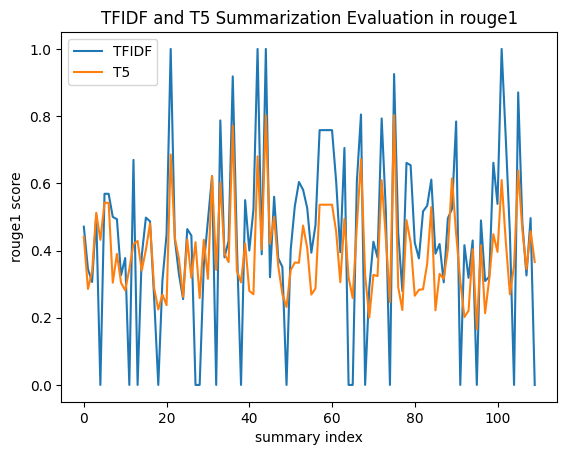

In [ ]:
plot_rouge(df_final, 'rouge1')

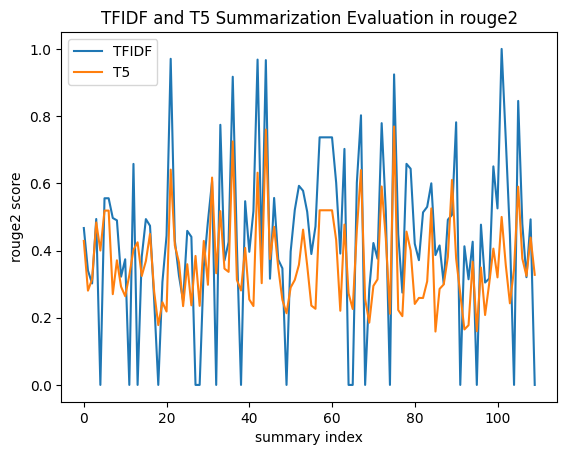

In [ ]:
plot_rouge(df_final, 'rouge2')

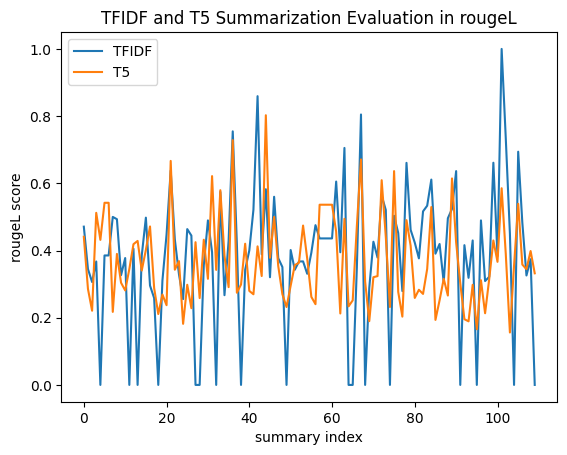

In [ ]:
plot_rouge(df_final, 'rougeL')